In [1]:
# Let's think of this problem as of monocular visual SLAM problem

In [2]:
import sys
import cv2
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
FPS = 20
# DELAY = int(1.0 / FPS * 1000)
FOCAL = 910  # pixels

In [4]:
# List files with videos and velocities
videos = sorted(glob.glob('labeled/*.hevc'))
vels = sorted(glob.glob('labeled/*.txt'))

In [5]:
# Read first video and velocities
curr_vel, curr_vid = vels[0], videos[0]

In [6]:
# Load all images from capture
imgs = []
cap = cv2.VideoCapture(curr_vid)
dir_x_y = np.loadtxt(curr_vel)
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        imgs.append(frame)
    else:
        print('All images read')
        break
imgs = np.array(imgs)
cap.release()
H, W = imgs[0].shape[:2]
CX = W / 2
CY = H / 2
K = np.array([[FOCAL,     0, CX], 
              [    0, FOCAL, CY], 
              [    0,     0,  1]])

All images read


In [7]:
dir_x_y.shape

(1200, 2)

In [8]:
imgs.shape

(1200, 874, 1164, 3)

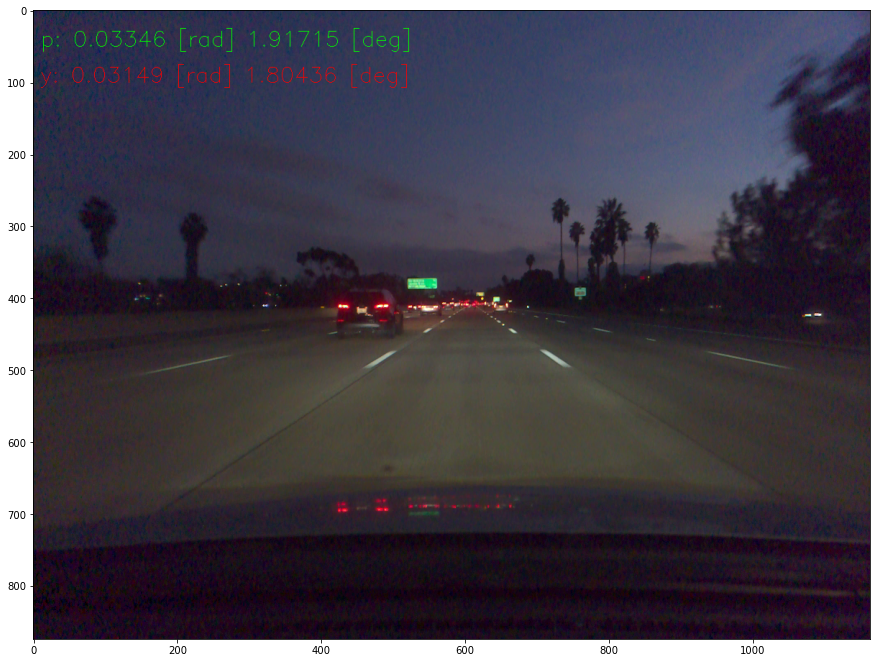

In [9]:
# Visualize single frame
frame_no = 0
frame = imgs[frame_no].copy()
pitch = dir_x_y[frame_no][0]
pitch_deg = np.rad2deg(pitch)
yaw = dir_x_y[frame_no][1]
yaw_deg = np.rad2deg(yaw)
cv2.putText(img=frame,
            text=f'p: {pitch:.5f} [rad] {pitch_deg:.5f} [deg]',
            org=(10, 50),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1,
            color=(0, 255, 0))
cv2.putText(img=frame,
            text=f'y: {yaw:.5f} [rad] {yaw_deg:.5f} [deg]',
            org=(10, 100),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1,
            color=(255, 0, 0))
plt.figure(figsize=(15, 15))
plt.imshow(frame)

In [22]:
# def feature_tracking(image0, image1, pts0, pts1):
#     p1, st, err = cv.calcOpticalFlowPyrLK(image0, image1, pts0, None)
    
    
    
    
def feature_detection(image):
    pts = cv2.goodFeaturesToTrack(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), maxCorners=3000, qualityLevel=0.01, minDistance=7) 
    # pts = np.squeeze(pts)
    return pts

In [23]:

# # Run for first two frames
# gray0 = cv2.cvtColor(imgs[0], cv2.COLOR_RGB2GRAY)
# gray1 = cv2.cvtColor(imgs[1], cv2.COLOR_RGB2GRAY)
n_features = 0
R = np.zeros((3, 3))
t = np.zeros((3, 3))
for i in range(1, len(imgs)):
    old_frame = imgs[i - 1]
    cur_frame = imgs[i]
    if n_features < 2000:
        p0 = feature_detection(old_frame)
        
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_frame, cur_frame, p0, None)
    
    good_old = p0[st == 1]
    good_new = p1[st == 1]
    
    if i < 2:
        E, _ = cv2.findEssentialMat(good_new, good_old, K)
        _, R, t, _ = cv2.recoverPose(E, p0, p1, K, R, t)
    else:
        E, _ = cv2.findEssentialMat(good_new, good_old, K)
        _, R, t, _ = cv2.recoverPose(E, p0, p1, K, R.bcopy(), t.copy())
        
    n_features = good_new.shape[0]
        
    
    

error: OpenCV(4.5.4) /tmp/pip-req-build-24v3eisa/opencv/modules/calib3d/src/undistort.dispatch.cpp:591: error: (-215:Assertion failed) npoints >= 0 && src.isContinuous() && (depth == CV_32F || depth == CV_64F) in function 'undistortPoints'


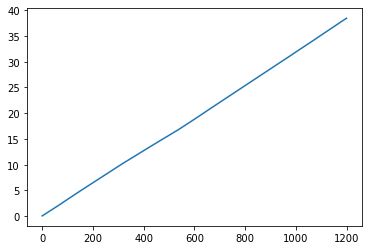

In [14]:
x, y = [dir_x_y[0, 0]], [dir_x_y[0, 1]]
for i in range(1, dir_x_y.shape[0]):
    x.append(x[i - 1] + dir_x_y[i, 0])
    y.append(y[i - 1] + dir_x_y[i, 1])

plt.figure()
plt.plot(y)